[구글 코랩에서 열기](https://colab.research.google.com/github/turbok2/python_basic/blob/main/20230131/ML_Classification_method_compare.ipynb)   2023.1.31

- 코랩에서 열리면 상단 메뉴 - 파일 - 드라이브에 사본 저장 선택
- 새탭으로 열기 선택
- 이 파일은 강사의 소유이므로 여기서 여러 사람이 실행하면 문제 발생함,  복사본을 만들어 자신의 구글드라이브에 복사된 걸 사용해야 함
- 상단의 파일이름을 클릭하고 원하는 이름으로 변경
- diabetes.csv 처럼 외부 파일이 필요하면 Colab의 좌측 메뉴에서 [문서철]아이콘을 누르고 sample_data 아래 영역에 다운 받은 파일(diabetes.csv)을 drag & drop 하시면 됩니다. (단 이 파일은 임시적으로 저장된 것이라 다음에 다시 접속하면 없습니다. 영구적으로 사용하려면 구글드라이브에 복사하고 연결하셔야 합니다.)

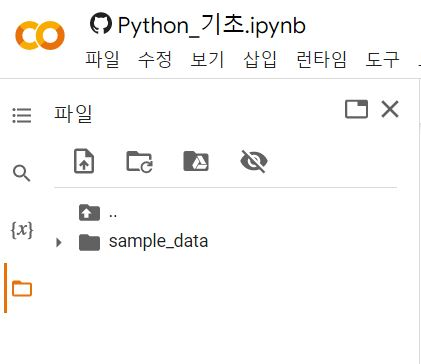

- 목표: 피마 인디언 당뇨병 데이트 세트를 이용하여 당뇨병 여부를 판단하기 위하여 여러가지 모델을 적용

# 피마 당뇨병 데이터 세트 구성  
- Pregnancies : 임신횟수  
- Glucose : 포도당 부하 검사 수치  
- BloodPressure : 혈압  
- SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값  
- Insulin : 혈청 인슐린  
- BMI : 체질량 지수  
- DiabetesPedigreeFunction : 당뇨 내력 가중치 값  
- Age : 나이  
- Outcome : 당뇨여부(0 또는 1)  

- 데이터 다운 경로
  https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download

# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer


import warnings
warnings.filterwarnings('ignore')

C:\Users\turbo\.conda\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\turbo\.conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\turbo\.conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# 데이터 불러오기

In [291]:
diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


전체 768개의 데이터 중 Positive 값 (1)이 268개, Negative(0) 값이 500개로 구성되어 있음

In [3]:
# diabetes 데이터 갼략히 보기(feature type 및 Null 값 개수 보기)
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Null 값은 존재하지 않으며 모두 int, float의 숫자형 데이터

--> Null 값과 문자열 처리를 위한 별도의 작업은 필요하지 않음

- 실제 현장의 데이터나 본인이 가진 의료 데이터는 전처리에 많은 노력이 필요하고, 여기서 정확도가 거의 결정됩니다.

# 다양한 방법으로 분류하기

In [4]:
# 평가지표 출력하는 함수 설정
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [282]:
# 피쳐 데이터 세트 X, 레이블 데이터 세트 y 를 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data['Outcome']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# 데이터를 훈련과 테스트 데이터 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

## Decision Tree

In [130]:
from sklearn.tree import DecisionTreeClassifier

In [131]:
dt_clf = DecisionTreeClassifier(random_state=20)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[78 22]
 [26 28]]

정확도: 0.6883
정밀도: 0.5600
재현율: 0.5185
F1: 0.5385
AUC: 0.6493


## KNN(K-Nearest Neighbors)

In [132]:
from sklearn.neighbors import KNeighborsClassifier

In [133]:
knn_clf = KNeighborsClassifier(n_neighbors = 2)
knn_clf.fit(X_train, y_train)
pred = knn_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[88 12]
 [37 17]]

정확도: 0.6818
정밀도: 0.5862
재현율: 0.3148
F1: 0.4096
AUC: 0.5974


## Naive Bayes

In [134]:
from sklearn.naive_bayes import GaussianNB

In [135]:
nb_clf =GaussianNB()
nb_clf.fit(X_train, y_train)
pred = nb_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[86 14]
 [17 37]]

정확도: 0.7987
정밀도: 0.7255
재현율: 0.6852
F1: 0.7048
AUC: 0.7726


## SVM

In [136]:
from sklearn.svm import SVC

In [137]:
svc_clf =SVC() 
svc_clf.fit(X_train, y_train)
pred = svc_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[88 12]
 [24 30]]

정확도: 0.7662
정밀도: 0.7143
재현율: 0.5556
F1: 0.6250
AUC: 0.7178


## Logistic Regression

- 로지스틱회귀 : 대표적인 머신러닝 방법  
데이터의 종류와 예측의 목적에 적합한 방법을 여러가지 시도해보고 가장 좋은 방법을 선택

In [ ]:
# 로지스틱 회귀로 학습, 예측 및 평가 수행
from sklearn.linear_model import LogisticRegression

In [140]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[90 10]
 [21 33]]

정확도: 0.7987
정밀도: 0.7674
재현율: 0.6111
F1: 0.6804
AUC: 0.7556


## Light GBM

In [256]:
import lightgbm as lgb

In [267]:
# lgb_clf = lgb.LGBMClassifier(learning_rate=0.03,boosting_type='gbdt', num_leaves=5, objective='binary',metric='binary_logloss',sub_feature=0.1,min_data=20,max_depth=3, max_bin=100) #79.22
# lgb_clf = lgb.LGBMClassifier(learning_rate=0.027,boosting_type='gbdt', num_leaves=6, objective='binary',metric='binary_logloss',sub_feature=0.18,min_data=28,max_depth=4, max_bin=100)
lgb_clf = lgb.LGBMClassifier(learning_rate=0.03,boosting_type='gbdt', num_leaves=6, objective='binary',metric='binary_logloss',sub_feature=0.1,min_data=28,max_depth=4, max_bin=100)

evals = [(X_test, y_test)]
lgb_clf.fit(X_train, y_train)
pred = lgb_clf.predict(X_test)
get_clf_eval(y_test, pred)

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.1. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=28. Current value: min_data_in_leaf=28
오차행렬:
 [[96  4]
 [28 26]]

정확도: 0.7922
정밀도: 0.8667
재현율: 0.4815
F1: 0.6190
AUC: 0.7207


## XGBoost

In [270]:
from xgboost import XGBClassifier

In [271]:
# 피쳐 데이터 세트 X, 레이블 데이터 세트 y 를 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data['Outcome']

# 데이터를 훈련과 테스트 데이터 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

In [272]:
# xg_clf=XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=4,min_child_weight=1)
xg_clf=XGBClassifier(max_depth=3,min_child_weight=3)

evals = [(X_test, y_test)]
xg_clf.fit(X_train, y_train,early_stopping_rounds=500,eval_set=evals, eval_metric="rmse",  verbose=False)
pred = xg_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[87 13]
 [22 32]]

정확도: 0.7727
정밀도: 0.7111
재현율: 0.5926
F1: 0.6465
AUC: 0.7313


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

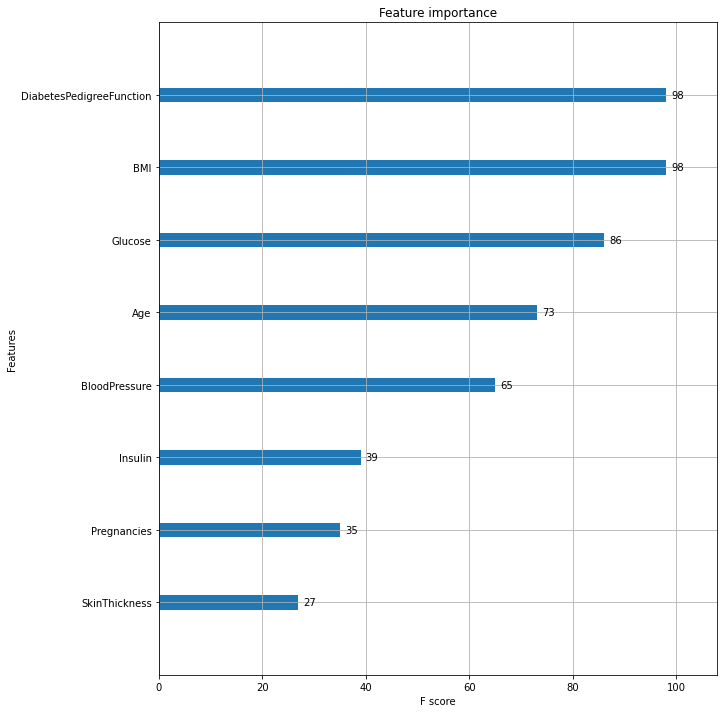

In [273]:
# feature 중요도도 그려볼 수 있다. 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xg_clf, ax=ax)

# Deploy

실제 적용을 가정하여 새로운 환자 n명의 정보를 입력하여 당뇨병 여부를 판단하는 방법

In [318]:
# Outcome : 당뇨여부(0 또는 1)
diabetes_data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [342]:
n=10
target = diabetes_data.sample(n)
target = target.drop('Outcome',axis=1)
target

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
681,0,162,76,36,0,49.6,0.364,26
221,2,158,90,0,0,31.6,0.805,66
252,2,90,80,14,55,24.4,0.249,24
105,1,126,56,29,152,28.7,0.801,21
440,0,189,104,25,0,34.3,0.435,41
143,10,108,66,0,0,32.4,0.272,42
258,1,193,50,16,375,25.9,0.655,24
219,5,112,66,0,0,37.8,0.261,41
376,0,98,82,15,84,25.2,0.299,22
738,2,99,60,17,160,36.6,0.453,21


In [343]:
X = diabetes_data.iloc[:,:-1]
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [344]:
# 학습할 때 사용한 전처리 방법 그대로 적용
feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# 0 값들을 우선 NaN 값으로 대체
target[feature_list] = target[feature_list].replace(0, np.nan)

# 위 5개 feature 에 대해 0값을 평균 값으로 대체
mean_features = target[feature_list].mean()
target[feature_list] = target[feature_list].replace(np.nan, mean_features)

# 정규화
X_scaled = scaler.transform(target)

In [345]:
pred_result = lr_clf.predict_proba(X_scaled.reshape(n,-1))
print(pred_result)
# 확률 높은 쪽으로 추론

[[0.20583387 0.79416613]
 [0.31911071 0.68088929]
 [0.96711054 0.03288946]
 [0.73530304 0.26469696]
 [0.27987981 0.72012019]
 [0.69162745 0.30837255]
 [0.26022829 0.73977171]
 [0.67513087 0.32486913]
 [0.96269545 0.03730455]
 [0.8265681  0.1734319 ]]


In [349]:
for result in pred_result:
    rclass=0
    if result[0] < result[1]:
        rclass=1
    print(f'{result}   \t {rclass}')

[0.20583387 0.79416613]   	 1
[0.31911071 0.68088929]   	 1
[0.96711054 0.03288946]   	 0
[0.73530304 0.26469696]   	 0
[0.27987981 0.72012019]   	 1
[0.69162745 0.30837255]   	 0
[0.26022829 0.73977171]   	 1
[0.67513087 0.32486913]   	 0
[0.96269545 0.03730455]   	 0
[0.8265681 0.1734319]   	 0
